Mount google drive to access training, val, and test data



In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)

!cp '/content/gdrive/My Drive/cs230/corrections.csv' corrections.csv
!cp '/content/gdrive/My Drive/cs230/val_256_edited.zip' val_256_edited.zip
!unzip val_256_edited.zip -d val_256_edited

Streaming output truncated to the last 5000 lines.
  inflating: val_256_edited/val_256_edited/Places365_val_00010810.jpg  
  inflating: val_256_edited/val_256_edited/Places365_val_00021415.jpg  
  inflating: val_256_edited/val_256_edited/Places365_val_00009399.jpg  
  inflating: val_256_edited/val_256_edited/Places365_val_00029049.jpg  
  inflating: val_256_edited/val_256_edited/Places365_val_00031606.jpg  
  inflating: val_256_edited/val_256_edited/Places365_val_00016252.jpg  
  inflating: val_256_edited/val_256_edited/Places365_val_00036182.jpg  
  inflating: val_256_edited/val_256_edited/Places365_val_00019161.jpg  
  inflating: val_256_edited/val_256_edited/Places365_val_00006041.jpg  
  inflating: val_256_edited/val_256_edited/Places365_val_00020938.jpg  
  inflating: val_256_edited/val_256_edited/Places365_val_00026391.jpg  
  inflating: val_256_edited/val_256_edited/Places365_val_00009372.jpg  
  inflating: val_256_edited/val_256_edited/Places365_val_00010623.jpg  
  inflating: 

In [ ]:
import csv
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
y = []
with open('corrections.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            print(f'Column names are {", ".join(row)}')
            line_count += 1
        else:
            row2 = [row[0]] + ([float(x) for x in row[1:]])
            y.append(row2)
            line_count += 1
y = sorted(y, key = lambda x:x[0])

Column names are filename, brightness, contrast, saturation, lightness


In [ ]:
img_height = 128
img_width = 128
batch_size = 32

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  'val_256_edited',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 36421 files belonging to 1 classes.
Using 29137 files for training.


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
print(tf.executing_eagerly())

# list_ds = tf.data.Dataset.list_files('val_256_edited/*/*', shuffle=False)
filenames = [x[0] for x in y]
labels = [x[1:] for x in y]

list_ds = tf.data.Dataset.from_tensor_slices((filenames, labels))

image_count = len(os.listdir('val_256_edited/val_256_edited/'))

list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

# for f in list_ds.take(5):
#   print(f.numpy())

def decode_img(img):
  img = tf.io.decode_jpeg(img, channels=3)
  return tf.image.resize(img, [img_height, img_width])

def get_features(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  print(parts[-1])
  return parts[-1]

def map_features(file_path, label):
  #print(file_path)
  #print("file_path: ",bytes.decode(file_path),type(bytes.decode(file_path)))
  # label = get_features(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file("val_256_edited/val_256_edited/"+file_path)
  img = decode_img(img)
  return img, label

train_ds = train_ds.map(map_features, num_parallel_calls=AUTOTUNE)
#train_ds = train_ds.map(lambda x: tf.py_function(map_features, [x], [tf.string]))
val_ds = val_ds.map(map_features, num_parallel_calls=AUTOTUNE)

for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  #print("Image: ", image.numpy())
  print("Label: ", label.numpy())

True
Image shape:  (128, 128, 3)
Label:  [-0.11883297  1.4327552   0.08478137  0.25159857]


Show some of the images in the dataset to make sure that the dataset was created properly


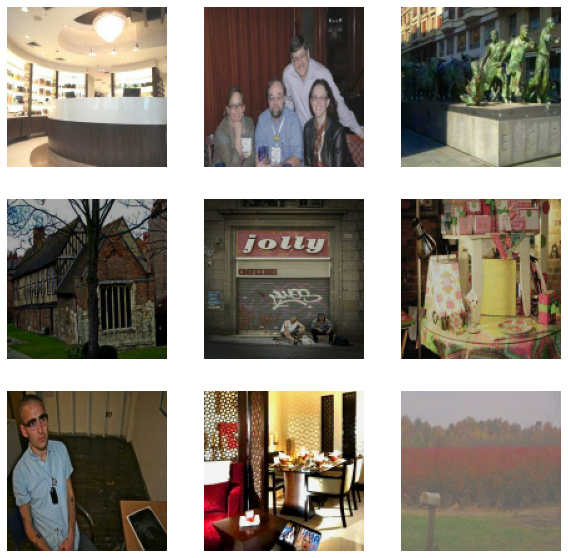

In [ ]:
import matplotlib.pyplot as plt

def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  #label = label_batch[i]
  #plt.title(class_names[label])
  plt.axis("off")

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
num_features = 4
model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_features)
])

In [ ]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.CosineSimilarity(),
  metrics=['accuracy'])

model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
911/911 [==============================] - 587s 643ms/step - loss: -0.9057 - accuracy: 0.9555 - val_loss: -0.9139 - val_accuracy: 0.9585
Epoch 2/3
911/911 [==============================] - 557s 611ms/step - loss: -0.9193 - accuracy: 0.9564 - val_loss: -0.9188 - val_accuracy: 0.9585
Epoch 3/3
911/911 [==============================] - 553s 607ms/step - loss: -0.9250 - accuracy: 0.9564 - val_loss: -0.9277 - val_accuracy: 0.9585


In [ ]:
model.save("model_v1.h5")

In [ ]:
# image_file = tf.keras.utils.get_file("val_256_edited/val_256_edited/Places365_val_00011739.jpg")
# img = tf.keras.preprocessing.image.load_img("val_256_edited/val_256_edited/Places365_val_00011739.jpg")
# image_array = tf.keras.preprocessing.image.img_to_array(img)
images = []
labels = []
for image, label in train_ds.take(32):
  images.append(image)
  labels.append(label)

model.predict(images, batch_size=32)
print(labels)



Consider rewriting this model with the Functional API.
[<tf.Tensor: shape=(32, 4), dtype=float32, numpy=
array([[ 0.11841471,  1.5746607 , -0.31855428, -0.02338142],
       [-0.1465204 ,  1.3975002 ,  0.11007483,  0.11242206],
       [ 0.03414815,  1.2198617 ,  0.6978041 , -0.06452513],
       [ 0.00847777,  1.602722  ,  0.29253355,  0.05964427],
       [ 0.03435335,  1.2133509 ,  0.0369628 ,  0.06291802],
       [-0.09561183,  0.7700705 , -0.06580459, -0.05881971],
       [ 0.41190735,  0.63224417,  0.14399537,  0.03904905],
       [-0.4485954 ,  1.213792  , -0.24154218,  0.30207705],
       [ 0.36574033,  0.38648236, -0.6787851 ,  0.26714045],
       [-0.25978   ,  1.1798021 , -0.09084869, -0.0629106 ],
       [-0.17866413,  1.1639851 ,  0.59517246, -0.08048721],
       [ 0.00957965,  0.7206621 ,  0.10827971,  0.04550685],
       [-0.00706138,  0.98584735, -0.45558178,  0.05820506],
       [-0.34838083,  1.0835886 ,  0.07875265, -0.01545729],
       [-0.2564673 ,  0.56289   , -0.1469